## Import dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.datasets import fetch_datasets
data = fetch_datasets()['wine_quality']

Using TensorFlow backend.


In [2]:
data.data.shape

(4898, 11)

In [3]:
labels=data.target

In [4]:
features=data.data
features.shape

(4898, 11)

In [5]:
features_0=features[np.where(labels!=1)]

In [6]:
print('Majority class data points:', features_0.shape[0])

Majority class data points: 4715


## LoRAS algorithm

### Usage guidelines

- The main function for LoRAS is LoRAS_gen. To generate LoRAS samples copy te code in the next cell and run the **LoRAS_gen** function following these guidelines.    

- The **LoRAS_gen** function takes and input the training data matrix and corresponding labels in form of numpy arrays. It is designed for only binary classificaion problems in version. Please make sure that the minority class labels are  set to $1$.

- Other parameters are **convex_neighbourhood**, **shadow**, **sigma**, **num_RACOS**, **num_convcomb**

- **convex_neighbourhood** corresponds to the parameter $k$ from the pseudocode in the original article. The standard value of this parameter shouldbe $5-10$. However for larger datasets (minority class size more than 500) it can be extended to $20-30$.

- **shadow** corresponds to the parameter $|S_p|$ from the pseudocode in the original article. The standard value of this parameter is to be kept around $100$.

- **sigma** corresponds to the standrd deviation for a Gaussian distribution to draw noise from. The standard value of sigma can be taken  as $0.005$. Although in the original pseudocode it is proposed that a list of feature-wise sigma values is taken as input, we have noticed that a standard value of small enough sigma works quite well. 

- **num_RACOS** corresponds to the paramter $N_{gen}$ from the original pseudocode. The standard value for this parameter is $int(\frac{|C^T_{maj}|-|C^T_{min}|}{|C^T_{min}|})$, where $|C^T_{maj}|$ and $|C^T_{min}|$ are the number of majority and minority instances in the training dataset, that is provided as input to the **LoRAS_gen** function and the $int$ function refers to the gratest integer floor function in case $\frac{|C^T_{maj}|-|C^T_{min}|}{|C^T_{min}|}$ is a float value. 

- **num_convcomb** corresponds to the parameter $N_{aff}$ from the original pseudocode.

                                                    ::CAUTION::
                                                    
**The algorithm is most sensitive to the num_convcomb parameter. For high dimensional datasets with $F$ feature we highly recommend an user to optimize this parameter with values** [$2$, $int(\frac{F}{4})$, $int(\frac{F}{2})$, $F$], **and use the optimal parameter value, to get the best out of this algorithm.**

**Also, note that if you have normalized your data before training models please use a sigma value of 0.00000005**

In [7]:
### COPY THE CODE IN THIS CELL TO USE LoRAS UMAP. RUN THE LoRAS_UMAP_gen FUNCTION WITH APPROPRIATE PARAMETERS.
### SEE EXAMPLE USAGE IN NEXT CELL 

from sklearn.manifold import TSNE

def Neb_grps(data,near_neb):
    'Function calculating nearest near_neb neighbours (among input data points), for every input data point'
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=near_neb, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    neb_class=[]
    for i in (indices):
        neb_class.append(i)
    return(np.asarray(neb_class)) 

def LoRAS(data,convex_neighbourhood,shadow,sigma,num_RACOS,num_convcom):
    'Function creating LoRAS samples for one minority data point neighbourhood'
    np.random.seed(42)
    data_shadow=([])
    for i in range (convex_neighbourhood):
        c=0
        while c<shadow:
            data_shadow.append(data[i]+np.random.normal(0,sigma))
            c=c+1
    data_shadow==np.asarray(data_shadow)
    data_shadow_lc=([])
    for i in range(num_RACOS):
        idx = np.random.randint(shadow*convex_neighbourhood, size=num_convcom)
        w=np.random.randint(100, size=len(idx))
        aff_w=np.asarray(w/sum(w))
        data_tsl=np.array(data_shadow)[idx,:]
        data_tsl_=np.dot(aff_w, data_tsl)
        data_shadow_lc.append(data_tsl_)
    return(np.asarray(data_shadow_lc))   

def LoRAS_gen(data,labels, convex_neighbourhood, shadow,sigma, num_RACOS, num_convcom, embedding):
    'Main LoRAS function performing preffered dimension reduction'
    'For UMAP use embedding="umap"'
    'For t-SNE use embedding="tsne"'
    'For regular use embedding="regular"'
    import numpy as np
    import umap.umap_ as umap
    
    features_1_trn=data[np.where(labels==1)]
    features_0_trn=data[np.where(labels!=1)]
    n_feat=features_0_trn.shape[1]
    if embedding == 'umap':
        umap_neighbourhood = int(input("Enter umap_neighbourhood:"))
        data_embedded_min = umap.UMAP(n_neighbors=umap_neighbourhood, min_dist=0.00000001, n_components=2, metric='euclidean', random_state=11).fit_transform(features_1_trn)
        nb_list=Neb_grps(data_embedded_min,  convex_neighbourhood)
        print('UMAP for minority class: Done\n')
    elif embedding == 'tsne':
        perp = int(input("Enter perplexity:"))
        data_embedded_min = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(features_1_trn)
        nb_list=Neb_grps(data_embedded_min,  convex_neighbourhood)
        print('t-SNE for minority class: Done\n')
    else:
        data_embedded_min = features_1_trn
        nb_list=Neb_grps(data_embedded_min,  convex_neighbourhood)
    
    RACOS_set=[]
    for i in range (len(nb_list)):
        RACOS_i= LoRAS(features_1_trn[nb_list[i]],convex_neighbourhood,shadow,sigma,num_RACOS,num_convcom)
        RACOS_set.append(RACOS_i)
    LoRAS_set=np.asarray(RACOS_set)
    LoRAS_1=np.reshape(LoRAS_set,(len(features_1_trn)*num_RACOS,n_feat))
    features_1_trn=np.concatenate((LoRAS_1,features_1_trn))
    print('Data generation: Done\n')
    return(np.concatenate((features_1_trn,features_0_trn)),np.concatenate((np.zeros(len(features_1_trn))+1, np.zeros(len(features_0_trn)))))

## LoRAS UMAP implementation

We demosntrate an implementation of LoRAS UMAP on the wine quality dataset

In [9]:
convex_neighbourhood=5
umap_neighbourhood=5
shadow=100
sigma=.005
num_RACOS=25
num_convcomb=3
embedding='tsne'
X,y=LoRAS_gen(features,labels, convex_neighbourhood, shadow,sigma, num_RACOS, num_convcomb, embedding)

Enter perplexity:10
t-SNE for minority class: Done

Data generation: Done



In [10]:
print('Synthetic samples generated:', X.shape[0]-features_0.shape[0])

Synthetic samples generated: 4758


## Visualization

In [11]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
palette = ['paleturquoise','c']

### Without oversampling

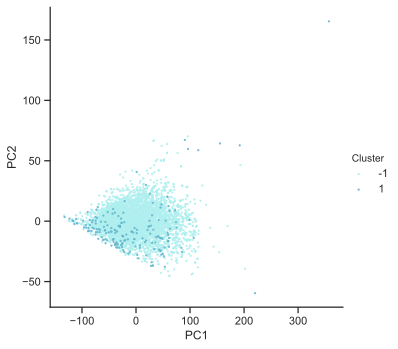

In [12]:
pca = PCA(n_components=2)
pc = pca.fit_transform(features)
result_baseline = pd.DataFrame(data = pc , 
        columns = ['PC1','PC2'])
result_baseline['Cluster'] = labels


sns.set(font_scale=1.2)
sns.set(rc={'figure.figsize':(12,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


g_baseline=sns.lmplot( x="PC1", y="PC2",
  data=result_baseline, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 2}, palette= sns.color_palette(palette) ) # specify the point size


plt.grid(False)
plt.show()

### LoRAS UMAP oversampling

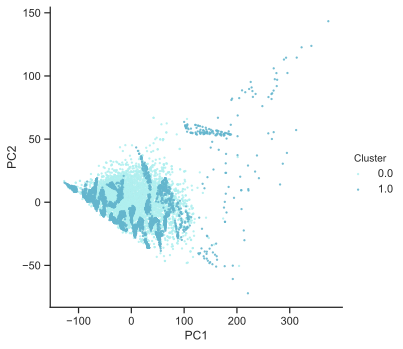

In [13]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
palette = ['paleturquoise','c']

pca = PCA(n_components=2)
pc = pca.fit_transform(X)
result_baseline = pd.DataFrame(data = pc , 
        columns = ['PC1','PC2'])
result_baseline['Cluster'] = y


sns.set(font_scale=1.2)
sns.set(rc={'figure.figsize':(12,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


g_baseline=sns.lmplot( x="PC1", y="PC2",
  data=result_baseline, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 2}, palette= sns.color_palette(palette) ) # specify the point size


plt.grid(False)
plt.show()